In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix,classification_report, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import joblib

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# LOADING THE DATASET

In [2]:
## Importing Data
df = pd.read_csv('hotel_bookings.csv')

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# DATA CLEANING AND PREPROCESSING

## Dealing with Missing Values

In [3]:
## Find the missing value, show the total null values for each column and sort it in descending order
df = df.copy()
df.isnull().sum().sort_values(ascending=False)[:10]

company                   112593
agent                      16340
country                      488
children                       4
reserved_room_type             0
assigned_room_type             0
booking_changes                0
deposit_type                   0
hotel                          0
previous_cancellations         0
dtype: int64

In [4]:
## If no id of agent or company is null, just replace it with 0
df[['agent','company']] = df[['agent','company']].fillna(0.0)

In [5]:
## For the missing values in the country column, replace it with mode (value that appears most often)
df['country'].fillna(df.country.mode().to_string(), inplace=True)


## for missing children value, replace it with rounded mean value
df['children'].fillna(round(df.children.mean()), inplace=True)

In [6]:
## Drop Rows where there is no adult, baby and child
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

In [7]:
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

## Converting Datatype

In [8]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [9]:
## convert datatype of these columns from float to integer
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

# Feature Selection

In [10]:
## Copy the dataframe
df_subset = df.copy()

In [11]:
## Make the new column which contain 1 if guest received the same room which was reserved otherwise 0
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1


## Make the new column which contain 1 if the guest has cancelled more booking in the past
## than the number of booking he did not cancel, otherwise 0

df_subset['net_cancelled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1

In [12]:
## Remove the less important features
df_subset = df_subset.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month',
                            'arrival_date_month','assigned_room_type','reserved_room_type','reservation_status_date',
                            'previous_cancellations','previous_bookings_not_canceled'],axis=1)

In [13]:
## Remove reservation_status column
## because it tells us if booking was cancelled 
df_subset = df_subset.drop(['reservation_status'], axis=1)

In [14]:
## Plot the heatmap to see correlation with columns
import dython
from dython.nominal import associations

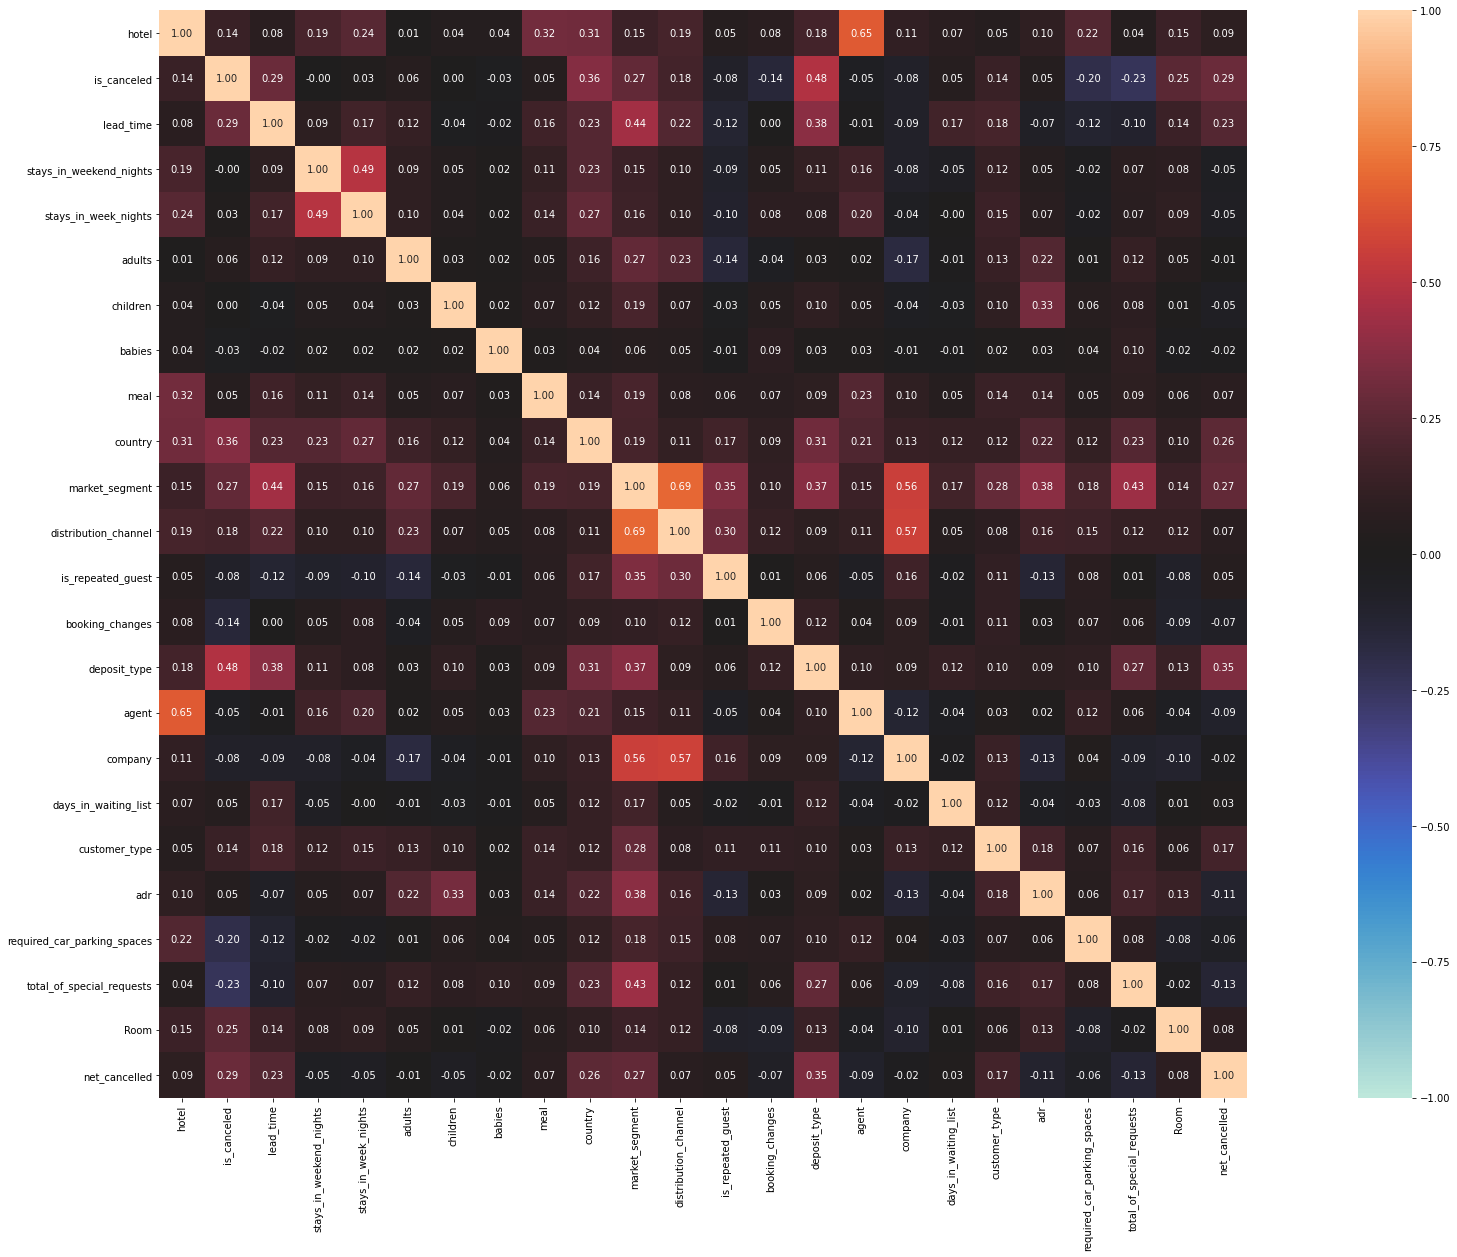

In [15]:
associations(df_subset, figsize = (40, 20))
plt.show()

In [16]:
df = df_subset
df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,Room,net_cancelled
0,Resort Hotel,0,342,0,0,2,0,0,BB,PRT,Direct,Direct,0,3,No Deposit,0,0,0,Transient,0.0,0,0,1,0
1,Resort Hotel,0,737,0,0,2,0,0,BB,PRT,Direct,Direct,0,4,No Deposit,0,0,0,Transient,0.0,0,0,1,0
2,Resort Hotel,0,7,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,No Deposit,0,0,0,Transient,75.0,0,0,0,0
3,Resort Hotel,0,13,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,No Deposit,304,0,0,Transient,75.0,0,0,1,0
4,Resort Hotel,0,14,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,No Deposit,240,0,0,Transient,98.0,0,1,1,0


# Model Building (Train &Test 3:1)

In [17]:
## Train and Test split on 77 percent and 33 percent.
X = df[['hotel','lead_time', 'market_segment', 'deposit_type', 'customer_type','Room','net_cancelled']]
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.33, random_state = 42)

In [18]:
X_train.head()

,hotel,lead_time,market_segment,deposit_type,customer_type,Room,net_cancelled
63119,City Hotel,56,Groups,Non Refund,Transient,1,0
92340,City Hotel,49,Online TA,No Deposit,Transient,0,0
102245,City Hotel,53,Online TA,No Deposit,Transient,1,0
20628,Resort Hotel,1,Corporate,No Deposit,Transient,1,0
23858,Resort Hotel,29,Direct,No Deposit,Transient,1,0


In [19]:
cat_columns = ['hotel','market_segment','deposit_type','customer_type']
num_columns = ['lead_time','Room','net_cancelled']

In [20]:
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

numerical_pipeline = Pipeline([
    ('scaler', RobustScaler())
])

prepocessor = ColumnTransformer([
    ('categorical',categorical_pipeline,cat_columns),
    ('numerical', numerical_pipeline,num_columns)
])

pipe_logreg = Pipeline([
    ("prep", prepocessor),
    ("algo", LogisticRegression())
])

pipe_DT = Pipeline([
    ("prep", prepocessor),
    ("algo", DecisionTreeClassifier())
])

# this is preparring all the the pipeline model to predict all using few algorithm and will hypertune it using
# the algorithm that we set up as well

## Logistic Regression

In [21]:
pipe_logreg.fit(X_train, y_train)
y_pred_logreg_base =  pipe_logreg.predict(X_test)
y_pred_logreg_base_train = pipe_logreg.predict(X_train)

In [22]:
recall_logreg_base = recall_score(y_test, y_pred_logreg_base)
acc_logreg_base = accuracy_score(y_test, y_pred_logreg_base)
precision_logreg_base = precision_score(y_test, y_pred_logreg_base)
f1_logreg_base = f1_score(y_test, y_pred_logreg_base)
acc_logreg_base_train = accuracy_score(y_train, y_pred_logreg_base_train)

print(f"Training Accuracy : {acc_logreg_base_train}")
print(f"Testing Accuracy : {acc_logreg_base}")

# here that the model is overfitting using logistic regression model

Training Accuracy : 0.775960936521848
Testing Accuracy : 0.77600406710727


In [23]:
print(classification_report(y_test, y_pred_logreg_base))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85     24754
           1       0.90      0.44      0.59     14586

    accuracy                           0.78     39340
   macro avg       0.83      0.71      0.72     39340
weighted avg       0.81      0.78      0.75     39340



In [24]:
cm_logreg_base = confusion_matrix(y_test, y_pred_logreg_base, labels = [1,0])
df_logreg_base = pd.DataFrame(data = cm_logreg_base, index = ['actual 1', 'actual 0'], columns = ['predictive 1', 'predictive 0'])
df_logreg_base

,predictive 1,predictive 0
actual 1,6470,8116
actual 0,696,24058


<AxesSubplot:>

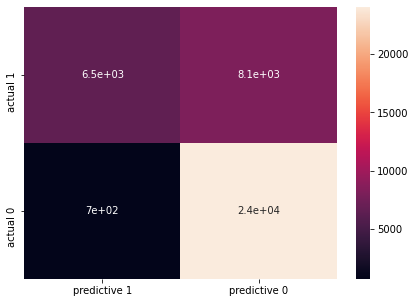

In [25]:
plt.figure(figsize = (7, 5))
sns.heatmap(df_logreg_base, annot = True)

## Decision Tree

In [26]:
pipe_DT.fit(X_train, y_train)
y_pred_DT_base =  pipe_DT.predict(X_test)
y_pred_DT_base_train = pipe_DT.predict(X_train)

In [27]:
recall_DT_base = recall_score(y_test, y_pred_DT_base)
acc_DT_base = accuracy_score(y_test, y_pred_DT_base)
precision_DT_base = precision_score(y_test, y_pred_DT_base)
f1_DT_base = f1_score(y_test, y_pred_DT_base)
acc_DT_base_train = accuracy_score(y_train, y_pred_DT_base_train)

print(f"Training Accuracy : {acc_DT_base_train}")
print(f"Testing Accuracy : {acc_DT_base}")

# here that the model is overfitting using decision tree model

Training Accuracy : 0.8063603355452611
Testing Accuracy : 0.7825876970005083


In [28]:
print(classification_report(y_test, y_pred_DT_base))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     24754
           1       0.79      0.57      0.66     14586

    accuracy                           0.78     39340
   macro avg       0.78      0.74      0.75     39340
weighted avg       0.78      0.78      0.77     39340



In [29]:
cm_DT_base = confusion_matrix(y_test, y_pred_DT_base, labels = [1,0])
df_DT_base = pd.DataFrame(data = cm_DT_base, index = ['actual 1', 'actual 0'], columns = ['predictive 1', 'predictive 0'])
df_DT_base

,predictive 1,predictive 0
actual 1,8244,6342
actual 0,2211,22543


<AxesSubplot:>

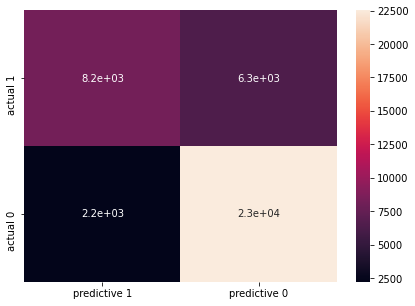

In [30]:
plt.figure(figsize = (7, 5))
sns.heatmap(df_DT_base, annot = True)

## Evaluation Comparing Each Models Evaluation Matrix

In [31]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [32]:
evaluation_matrix_base = {
    'Logistic Regression': [acc_logreg_base, recall_logreg_base, precision_logreg_base, f1_logreg_base],
    'Decision Tree':[acc_DT_base, recall_DT_base, precision_DT_base, f1_DT_base],
}

eva_base = pd.DataFrame(data = evaluation_matrix_base, index = ['Accucary', 'Recall', 'Precision', 'F1 Score'])

evaluation_matrix_base_training = {
    "Training" : [acc_logreg_base_train, acc_DT_base_train],
    "Testing": [acc_logreg_base, acc_DT_base]
}
    

eva_base_train = pd.DataFrame(data = evaluation_matrix_base_training, index = ['Logreg', 'Decision Tree'])

display_side_by_side([eva_base, eva_base_train], ['Evaluation Matrix', 'Accuracy Train & Test'])

,Logistic Regression,Decision Tree
Accucary,0.776004,0.782588
Recall,0.443576,0.565200
Precision,0.902875,0.788522
F1 Score,0.594888,0.658440
,Training,Testing
Logreg,0.775961,0.776004
Decision Tree,0.806360,0.782588


# Hyperparameter Tuning

## Logistic Regression

In [33]:
pipe_logreg.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('categorical',
                                    Pipeline(steps=[('encoder', OneHotEncoder())]),
                                    ['hotel', 'market_segment', 'deposit_type',
                                     'customer_type']),
                                   ('numerical',
                                    Pipeline(steps=[('scaler', RobustScaler())]),
                                    ['lead_time', 'Room', 'net_cancelled'])])),
  ('algo', LogisticRegression())],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('categorical',
                                  Pipeline(steps=[('encoder', OneHotEncoder())]),
                                  ['hotel', 'market_segment', 'deposit_type',
                                   'customer_type']),
                                 ('numerical',
                                  Pipeline(steps=[('scaler', RobustScaler())]),
                             

In [34]:
param_logreg = {
    'algo__penalty':['l2', 'l1', 'elasticnet'],
    'algo__C':[1.0, 2.0, 3.0, 4.0,5.0],
    'algo__class_weight':[None, 'balanced']
}

model_logreg = GridSearchCV(estimator=pipe_logreg, param_grid=param_logreg, cv = 3, n_jobs = -1, verbose = 1, scoring='accuracy')
model_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['hotel',
                                                                          'market_segment',
                                                                          'deposit_type',
                                                                          'customer_type']),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          

In [35]:
logreg_tuned = model_logreg.best_estimator_
logreg_tuned_train = model_logreg.score(X_train, y_train)
y_pred_logreg_tuned = logreg_tuned.predict(X_test) 

In [36]:
recall_logreg_tuned = recall_score(y_test, y_pred_logreg_tuned)
acc_logreg_tuned = accuracy_score(y_test, y_pred_logreg_tuned)
precision_logreg_tuned = precision_score(y_test, y_pred_logreg_tuned)
f1_logreg_tuned = f1_score(y_test, y_pred_logreg_tuned)
acc_logreg_tuned_train = logreg_tuned_train

print(f"Training Accuracy : {acc_logreg_tuned_train}")
print(f"Testing Accuracy : {acc_logreg_tuned}")

Training Accuracy : 0.775960936521848
Testing Accuracy : 0.77600406710727


In [37]:
print(classification_report(y_test, y_pred_logreg_tuned))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85     24754
           1       0.90      0.44      0.59     14586

    accuracy                           0.78     39340
   macro avg       0.83      0.71      0.72     39340
weighted avg       0.81      0.78      0.75     39340



In [38]:
cm_logreg_tuned = confusion_matrix(y_test, y_pred_logreg_tuned, labels = [1,0])
df_logreg_tuned = pd.DataFrame(data = cm_logreg_tuned, index = ['actual 1', 'actual 0'], columns = ['predictive 1', 'predictive 0'])


display_side_by_side([df_logreg_base, df_logreg_tuned], ['Base Model', 'Tuned Model'])

# we see that comparing both of the model we see that base model has a slightly more True Positive 
# while tuned model has slightly more True Negative and and slightly less true  true positive

,predictive 1,predictive 0
actual 1,6470,8116
actual 0,696,24058
,predictive 1,predictive 0
actual 1,6470,8116
actual 0,696,24058


Text(0.5, 1.0, 'Tuned Model')

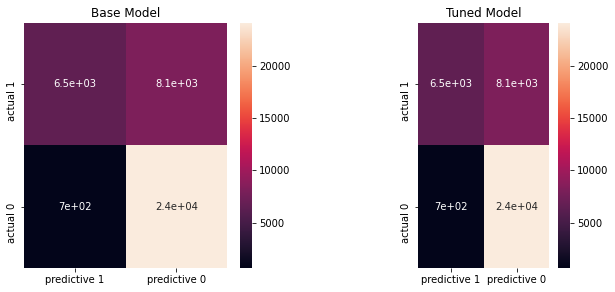

In [39]:
plt.figure(figsize = (10, 4.5))

plt.subplot(1,2,1)
sns.heatmap(df_logreg_base, annot = True)
plt.title('Base Model')

plt.subplot(1,3,3)
sns.heatmap(df_logreg_tuned, annot = True)
plt.title('Tuned Model')

# Decision Tree

In [40]:
pipe_DT.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('categorical',
                                    Pipeline(steps=[('encoder', OneHotEncoder())]),
                                    ['hotel', 'market_segment', 'deposit_type',
                                     'customer_type']),
                                   ('numerical',
                                    Pipeline(steps=[('scaler', RobustScaler())]),
                                    ['lead_time', 'Room', 'net_cancelled'])])),
  ('algo', DecisionTreeClassifier())],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('categorical',
                                  Pipeline(steps=[('encoder', OneHotEncoder())]),
                                  ['hotel', 'market_segment', 'deposit_type',
                                   'customer_type']),
                                 ('numerical',
                                  Pipeline(steps=[('scaler', RobustScaler())]),
                         

In [41]:
param_DT = {
    'algo__min_samples_split': [2,1,3,4,6,8,10,],
    'algo__max_depth': [None,1,2,4,8,10,12,14,18, 20],
    'algo__min_samples_leaf':[1,2,4,5,8]
}

model_DT = GridSearchCV(estimator=pipe_DT, param_grid=param_DT, cv = 3, n_jobs = -1, verbose = 1, scoring='accuracy')
model_DT.fit(X_train, y_train)

Fitting 3 folds for each of 350 candidates, totalling 1050 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['hotel',
                                                                          'market_segment',
                                                                          'deposit_type',
                                                                          'customer_type']),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          

In [42]:
DT_tuned = model_DT.best_estimator_
DT_tuned_train = model_DT.score(X_train, y_train)
y_pred_DT_tuned = DT_tuned.predict(X_test) 

In [43]:
recall_DT_tuned = recall_score(y_test, y_pred_DT_tuned)
acc_DT_tuned = accuracy_score(y_test, y_pred_DT_tuned)
precision_DT_tuned = precision_score(y_test, y_pred_DT_tuned)
f1_DT_tuned = f1_score(y_test, y_pred_DT_tuned)
acc_DT_tuned_train = DT_tuned_train

print(f"Training Accuracy : {acc_DT_tuned_train}")
print(f"Testing Accuracy : {acc_DT_tuned}")

Training Accuracy : 0.8063603355452611
Testing Accuracy : 0.7827147941026945


In [44]:
print(classification_report(y_test, y_pred_DT_tuned))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     24754
           1       0.79      0.57      0.66     14586

    accuracy                           0.78     39340
   macro avg       0.78      0.74      0.75     39340
weighted avg       0.78      0.78      0.77     39340



In [45]:
cm_DT_tuned = confusion_matrix(y_test, y_pred_DT_tuned, labels = [1,0])
df_DT_tuned = pd.DataFrame(data = cm_DT_tuned, index = ['actual 1', 'actual 0'], columns = ['predictive 1', 'predictive 0'])


display_side_by_side([df_DT_base, df_DT_tuned], ['Base Model', 'Tuned Model'])

,predictive 1,predictive 0
actual 1,8244,6342
actual 0,2211,22543
,predictive 1,predictive 0
actual 1,8245,6341
actual 0,2207,22547


Text(0.5, 1.0, 'Tuned Model')

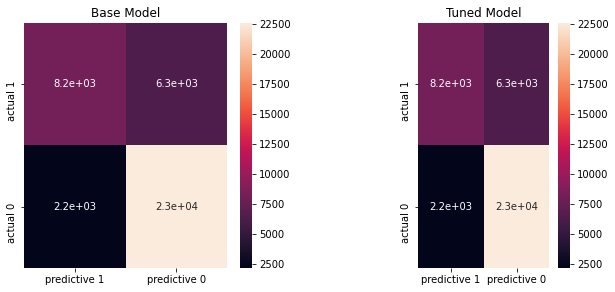

In [46]:
plt.figure(figsize = (10, 4.5))

plt.subplot(1,2,1)
sns.heatmap(df_DT_base, annot = True)
plt.title('Base Model')

plt.subplot(1,3,3)
sns.heatmap(df_DT_tuned, annot = True)
plt.title('Tuned Model')

In [47]:
evaluation_matrix_tuned = {
    'Logistic Regression': [acc_logreg_tuned, recall_logreg_tuned, precision_logreg_tuned, f1_logreg_tuned],
    'Decision Tree':[acc_DT_tuned, recall_DT_tuned, precision_DT_tuned, f1_DT_tuned],
}

eva_tuned = pd.DataFrame(data = evaluation_matrix_tuned, index = ['Accucary', 'Recall', 'Precision', 'F1 Score'])

evaluation_matrix_tuned_training = {
    "training" : [acc_logreg_tuned_train,acc_DT_tuned_train],
    "testing": [acc_logreg_tuned,acc_DT_tuned]
}

eva_tuned_train = pd.DataFrame(data = evaluation_matrix_tuned_training, index = ['Logreg','Decision Tree'])

## Comparing Each Evaluation Matrix

#### Base Model

In [48]:
display_side_by_side([eva_base, eva_base_train], ['Evaluation Matrix', 'Accuracy Train & Test'])

,Logistic Regression,Decision Tree
Accucary,0.776004,0.782588
Recall,0.443576,0.565200
Precision,0.902875,0.788522
F1 Score,0.594888,0.658440
,Training,Testing
Logreg,0.775961,0.776004
Decision Tree,0.806360,0.782588


#### Tuned Model

In [49]:
display_side_by_side([eva_tuned, eva_tuned_train], ['Evaluation Matrix', 'Accuracy Train & Test'])

,Logistic Regression,Decision Tree
Accucary,0.776004,0.782715
Recall,0.443576,0.565268
Precision,0.902875,0.788844
F1 Score,0.594888,0.658599
,training,testing
Logreg,0.775961,0.776004
Decision Tree,0.806360,0.782715
